##**Методы машинного обучения для оценки содержания азота в растениях по аэрофотоснимкам**

Этот блокнот предназначен для обучение классических методов машинного обучения.

**Подключение необходимых библиотек**

In [1]:
!pip install scikit-learn==1.5
import gdown
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, balanced_accuracy_score, jaccard_score
import xgboost as xgb

**Загрузка данных**

In [2]:
synth_url = 'https://drive.google.com/uc?id=1-2NNy9L3hedguXLwBCCYf7YEsmrxC67v'
test_url = 'https://drive.google.com/uc?id=1--GE0W5X7i0c-08In3LcWZ-VdnYbvOTT'
synth_path = "train_images_and_masks.npz"
test_path = "test_images_and_masks.npz"
gdown.download(synth_url, synth_path, quiet=False)
gdown.download(test_url, test_path, quiet=False)
synth_data = np.load(synth_path)
test_data = np.load(test_path)
train_images = synth_data["synth_images"][:500]
train_masks = synth_data["synth_masks"][:500]
test_images = test_data["test_images"][:500]
test_masks = test_data["test_masks"][:500]

Downloading...
From (original): https://drive.google.com/uc?id=1-2NNy9L3hedguXLwBCCYf7YEsmrxC67v
From (redirected): https://drive.google.com/uc?id=1-2NNy9L3hedguXLwBCCYf7YEsmrxC67v&confirm=t&uuid=66f9c59b-a21c-4f11-aca3-1040b6df6a80
To: /content/train_images_and_masks.npz
100%|██████████| 198M/198M [00:02<00:00, 74.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--GE0W5X7i0c-08In3LcWZ-VdnYbvOTT
To: /content/test_images_and_masks.npz
100%|██████████| 6.28M/6.28M [00:00<00:00, 43.2MB/s]


**Проверка данных и визуализация изображений**

In [3]:
print(train_images.shape)
print(train_masks.shape)
print(test_images.shape)
print(test_masks.shape)

(500, 128, 128, 6)
(500, 128, 128, 1)
(66, 128, 128, 6)
(66, 128, 128, 1)


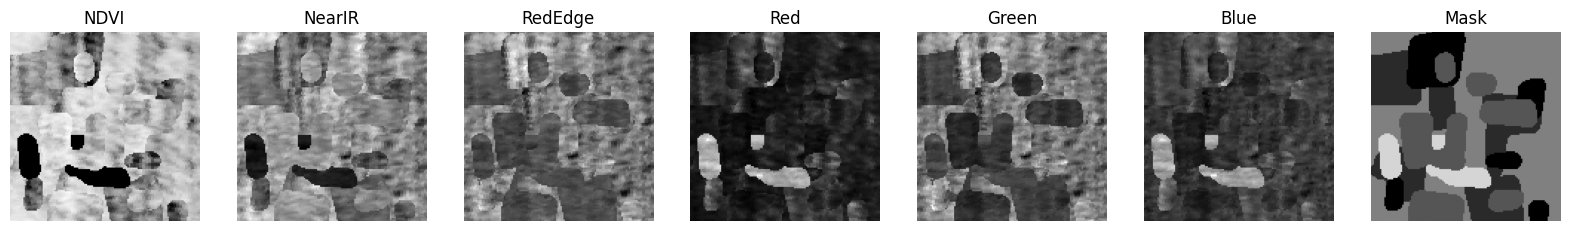

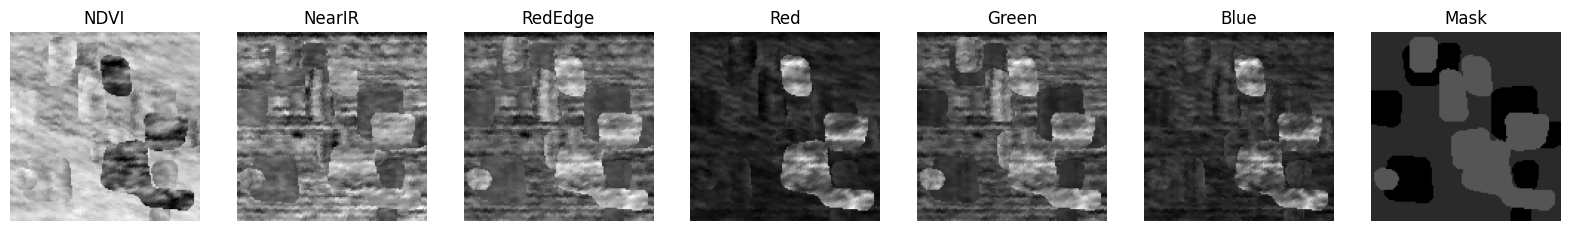

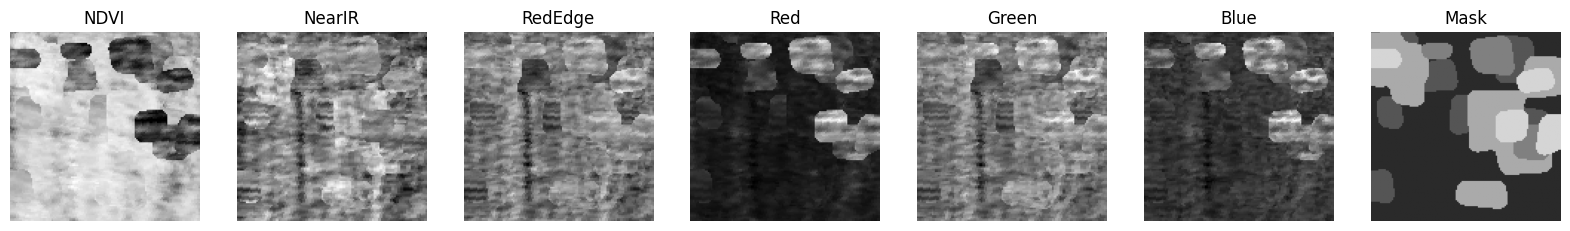

In [4]:
# Названия каналов для подписей
channel_names = ["NDVI", "NearIR", "RedEdge", "Red", "Green", "Blue"]

def visualize_samples(images, masks, num_samples=3):
    """
    Визуализирует несколько примеров изображений и их масок.

    Параметры:
    - images: numpy-массив изображений (размерность: [N, 128, 128, 6])
    - masks: numpy-массив масок (размерность: [N, 128, 128, 1])
    - num_samples: количество примеров для отображения
    """

    for i in range(num_samples):
        img = images[i]  # Берём одно изображение (6 каналов)
        mask = masks[i].squeeze()  # Убираем лишнюю ось (128, 128)

        fig, ax = plt.subplots(1, 7, figsize=(20, 5))

        # Визуализируем все 6 каналов с подписями
        for j in range(6):
            ax[j].imshow(img[:, :, j], cmap="gray")
            ax[j].set_title(channel_names[j])  # Добавляем подпись
            ax[j].axis("Off")

        # Визуализируем маску (размеченные классы)
        ax[-1].imshow(mask, cmap="gray", vmin=0, vmax=6)
        ax[-1].set_title("Mask")
        ax[-1].axis("Off")

        plt.show()

# Вызываем функцию для отображения 3 примеров
visualize_samples(train_images, train_masks)

**Преобразование данных специально для методов ML**

Функция prepare_data_for_ml подготавливает изображения и маски для использования в алгоритмах машинного обучения.

*   Проверка корректности входных данных:

Первые три измерения X и y должны совпадать → (N, H, W, C) для X и (N, H, W, 1) для y.
Последнее измерение y должно быть 1 (маска должна иметь один канал).

*   Преобразование X (изображения) в двумерный массив:

X из формы (N, H, W, C) превращается в (N * H * W, C)
Это делает каждый пиксель отдельным объектом с C признаками (каналы изображения).

*   Преобразование y (маски) в одномерный массив меток:

y из формы (N, H, W, 1) превращается в (N * H * W,)
Это делает каждую размеченную категорию (класс) одной числовой меткой.

In [5]:
def prepare_data_for_ml(X, y):

    assert X.shape[:3] == y.shape[:3], "Размеры X и y должны совпадать по первым трём измерениям"
    assert y.shape[-1] == 1, "Маска должна быть размером (N, H, W, 1)"

    N, H, W, C = X.shape

    # (N, H, W, C) -> (N * H * W, C)
    features = X.reshape(-1, C)

    # (N, H, W, 1) -> (N * H * W,)
    labels = y.reshape(-1)

    return features, labels

In [6]:
X_test, y_test = prepare_data_for_ml(test_images, test_masks)
X_train, y_train = prepare_data_for_ml(train_images, train_masks)
print(X_test.shape, y_test.shape)
print(X_train.shape, y_train.shape)

(1081344, 6) (1081344,)
(8192000, 6) (8192000,)


In [7]:
print(f"Массив X занимает {X_train.nbytes / (1024 ** 2):.2f} МБ")

Массив X занимает 375.00 МБ


**Обучение моделей**

Обучались модели Random Forest и XGBoost

In [8]:
def calculate_iou(y_true, y_pred):
    return jaccard_score(y_true, y_pred, average='macro')

def show_scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    mean_iou = calculate_iou(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

**Random Forest**

Самое первое обучение (без подбора гиперпараметров)

In [16]:
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [19]:
show_scores(y_test, y_pred)

Accuracy: 0.2841
Balanced Accuracy: 0.2841
Macro F1-score: 0.2852
Mean IoU: 0.1678


Подбор гиперпараметров при помощи кросс-валидации. Чтобы ускорить процесс, для подбора параметров была взята небольшая часть данных.

In [14]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

X_small, _, y_small, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
grid_search.fit(X_small, y_small)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2],
                         'n_estimators': [10, 20, 50]},
             scoring='accuracy', verbose=3)

In [15]:
print(f"Лучшие параметры: {grid_search.best_params_}")

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Обучение модели с лучшим набором параметров

In [ ]:
best_params = grid_search.best_params_
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

In [ ]:
show_scores(y_test, y_pred)